<a href="https://colab.research.google.com/github/crystal-zhu/Sitcom_Success_Factors-CSDS_312/blob/main/B99_Analysis/B99_GenderDistribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
pip install cupy-cuda11x

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 MB 2.4 MB/s eta 0:00:00


In [23]:
import numpy as np
import cupy as cp
import time

In [12]:
import requests
import pandas as pd

url = "https://raw.githubusercontent.com/crystal-zhu/Sitcom_Success_Factors-CSDS_312/main/B99_Analysis/data/B99_Script/Brooklyn99_Season1-4_Dataset.csv"
response = requests.get(url)


# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open("Brooklyn99_Season1-4_Dataset", "w") as f:
        f.write(response.text)
    print("CSV file downloaded successfully")
else:
    print("Failed to download CSV file. Status code:", response.status_code)

dialogue = pd.read_csv("Brooklyn99_Season1-4_Dataset")


CSV file downloaded successfully


In [3]:
female_chars = ['AMY', 'ROSA', 'GINA']
male_chars = ['JAKE', 'CHARLES', 'BOYLE', 'TERRY', 'HOLT', 'SCULLY', 'HITCHCOCK']

In [4]:
for char in female_chars:
  female_lines = dialogue[dialogue['name'] == char]
  print(char + ": " + str(len(female_lines)))


AMY: 448
ROSA: 267
GINA: 312


In [5]:
for char in male_chars:
  male_lines = dialogue[dialogue['name'] == char]
  print(char + ": " + str(len(male_lines)))


JAKE: 1202
CHARLES: 285
BOYLE: 188
TERRY: 315
HOLT: 534
SCULLY: 47
HITCHCOCK: 51


In [6]:
import re
import nltk

from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
import spacy
nlp = spacy.load("en_core_web_sm")
nlp

# Initialize the Porter Stemmer and WordNet Lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Gensim stopwords
gensim_stop_words = set(stopwords.words('english'))

# Remove punctuations, stopwords, convert to lowercase, tokenize, stem, and lemmatize
def preprocess_text(text):
    # Use spaCy for POS tagging
    processed = nlp(text)
    cleaned_text = re.sub(r'[^\w\s]', '', text) # remove all non-word and non-whitespace characters from the text

    # Keep only nouns
    nouns = [token.text for token in processed if token.pos_ in ["NOUN", "VERB", "ADVERB", "DET", "X"]]

    stop_words = set(gensim_stop_words)
    words = word_tokenize(cleaned_text.lower())
    filtered_words = [word for word in words if word not in stop_words and len(word) >= 4] # remove words have less than 4 characters

    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]

    return nouns

# Apply preprocessing to the 'text' column
start_time = time.time()  # Record start time
dialogue['processed_text'] = dialogue['line'].apply(preprocess_text)
end_time = time.time()  # Record end time
elapsed_time = end_time - start_time  # Calculate elapsed time
print(f"Elapsed time for preprocessing: {elapsed_time:.4f} seconds")
dialogue.head()



Elapsed time for preprocessing: 62.8175 seconds


,name,line,processed_text
0,JAKE,This job is eating me alive. I can't breathe ...,"[This, job, eating, breathe, spent, all, these..."
1,AMY,"Hey! What are you doing, weirdo?","[doing, weirdo]"
2,JAKE,I'm doing the best speech from Donnie Brasco....,"[doing, the, speech, doing, the, speech, [, st..."
3,AMY,"Get it together, man. Okay?","[Get, man]"
4,AMY,So the store was hit about two hours ago. The...,"[the, store, hit, hours, took, tablets, laptop..."


In [29]:
# Function to determine gender based on character name
def get_gender(name):
    if name in female_chars:
        return 'Female'
    elif name in male_chars:
        return 'Male'
    else:
        return None

# Apply the function to create a new column 'Gender' in the DataFrame
dialogue['Gender'] = dialogue['name'].apply(get_gender)

# Display the DataFrame with the new column
dialogue.head()

,name,line,processed_text,Gender
0,JAKE,This job is eating me alive. I can't breathe ...,"[This, job, eating, breathe, spent, all, these...",Male
1,AMY,"Hey! What are you doing, weirdo?","[doing, weirdo]",Female
2,JAKE,I'm doing the best speech from Donnie Brasco....,"[doing, the, speech, doing, the, speech, [, st...",Male
3,AMY,"Get it together, man. Okay?","[Get, man]",Female
4,AMY,So the store was hit about two hours ago. The...,"[the, store, hit, hours, took, tablets, laptop...",Female


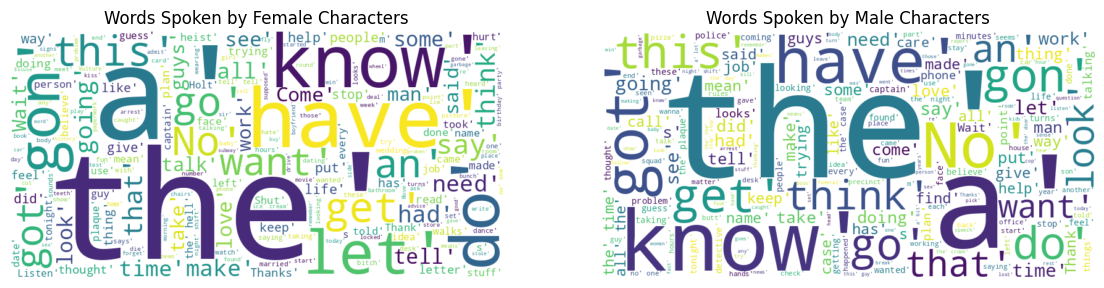

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate lines spoken by female characters
female_lines_concatenated = ' '.join(dialogue[dialogue['Gender'] == 'Female']['processed_text'].dropna().astype(str))

# Concatenate lines spoken by male characters
male_lines_concatenated = ' '.join(dialogue[dialogue['Gender'] == 'Male']['processed_text'].dropna().astype(str))

# # Generate word clouds for female and male characters
female_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(female_lines_concatenated)
male_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(male_lines_concatenated)

# # Plot the word clouds
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(female_wordcloud, interpolation='bilinear')
plt.title('Words Spoken by Female Characters')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(male_wordcloud, interpolation='bilinear')
plt.title('Words Spoken by Male Characters')
plt.axis('off')

plt.show()

In [32]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis on a string
def analyze_sentiment(text):
    # Get sentiment scores
    scores = sid.polarity_scores(text)
    # Determine sentiment based on compound score
    if scores['compound'] >= 0.05:

        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

def get_sentiment_score(text):
    # Get sentiment scores
    scores = sid.polarity_scores(text)
    # Return the compound score
    return scores['compound']

# Apply sentiment analysis to each text in the DataFrame
dialogue['Sentiment'] = dialogue['line'].apply(analyze_sentiment)
dialogue['SentimentScore'] = dialogue['line'].apply(get_sentiment_score)

dialogue

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,name,line,processed_text,Gender,Sentiment,SentimentScore
0,JAKE,This job is eating me alive. I can't breathe ...,"[This, job, eating, breathe, spent, all, these...",Male,Positive,0.5252
1,AMY,"Hey! What are you doing, weirdo?","[doing, weirdo]",Female,Negative,-0.4753
2,JAKE,I'm doing the best speech from Donnie Brasco....,"[doing, the, speech, doing, the, speech, [, st...",Male,Positive,0.8555
3,AMY,"Get it together, man. Okay?","[Get, man]",Female,Positive,0.2263
4,AMY,So the store was hit about two hours ago. The...,"[the, store, hit, hours, took, tablets, laptop...",Female,Neutral,0.0000
...,...,...,...,...,...,...
6455,AMY,You mean-,[mean-],Female,Neutral,0.0000
6456,JAKE,"Yes, Amy. We're back on the day shift!","[the, day, shift]",Male,Positive,0.4574
6457,TERRY,Nine-Nine!,[],Male,Neutral,0.0000
6458,ALL,Nine-Nine!,[],None,Neutral,0.0000


In [34]:
average_sentiment = dialogue.groupby('Gender')['SentimentScore'].mean()

print("Average sentiment score for male and female dialogue:")
print(average_sentiment)

Average sentiment score for male and female dialogue:
Gender
Female    0.050702
Male      0.073524
Name: SentimentScore, dtype: float64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


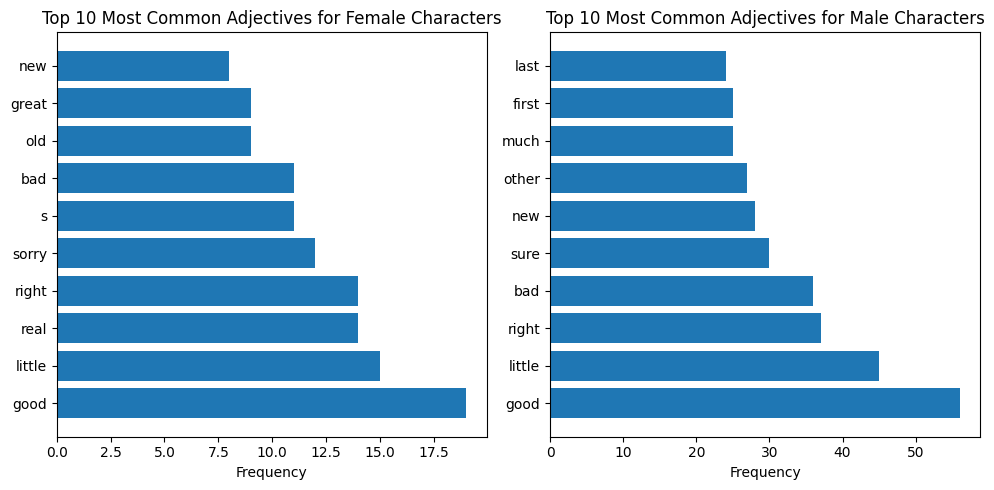

In [39]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to extract adjectives from text based on gender
def extract_adjectives(text, gender):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    adjectives = [word for word, pos in tagged_words if pos == 'JJ' and dialogue.loc[dialogue['line'] == text, 'Gender'].iloc[0] == gender]
    return adjectives

# Extract adjectives for female and male characters
female_adjectives = [adjective for text in dialogue[dialogue['Gender'] == 'Female']['line'] for adjective in extract_adjectives(text, 'Female')]
male_adjectives = [adjective for text in dialogue[dialogue['Gender'] == 'Male']['line'] for adjective in extract_adjectives(text, 'Male')]

# Count the occurrence of each adjective
female_adjectives_counts = Counter(female_adjectives)
male_adjectives_counts = Counter(male_adjectives)

# Sort adjectives based on their frequency
most_common_female_adjectives = female_adjectives_counts.most_common()
most_common_male_adjectives = male_adjectives_counts.most_common()

# print("Most commonly used adjectives for female characters:")
# for adj, count in most_common_female_adjectives:
#     print(adj, "-", count)

# print("\nMost commonly used adjectives for male characters:")
# for adj, count in most_common_male_adjectives:
#     print(adj, "-", count)


top_female_adjectives = dict(female_adjectives_counts.most_common(10))
top_male_adjectives = dict(male_adjectives_counts.most_common(10))

# Plot bar graphs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.barh(range(len(top_female_adjectives)), list(top_female_adjectives.values()), align='center')
plt.yticks(range(len(top_female_adjectives)), list(top_female_adjectives.keys()))
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Adjectives for Female Characters')

plt.subplot(1, 2, 2)
plt.barh(range(len(top_male_adjectives)), list(top_male_adjectives.values()), align='center')
plt.yticks(range(len(top_male_adjectives)), list(top_male_adjectives.keys()))
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Adjectives for Male Characters')

plt.tight_layout()
plt.show()